In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Import

In [21]:
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

warnings.filterwarnings('ignore')

# Explore dataset

In [22]:
df_train = pd.read_csv("files/Houses_train.csv")
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


### Correlation matrix (heatmap style)

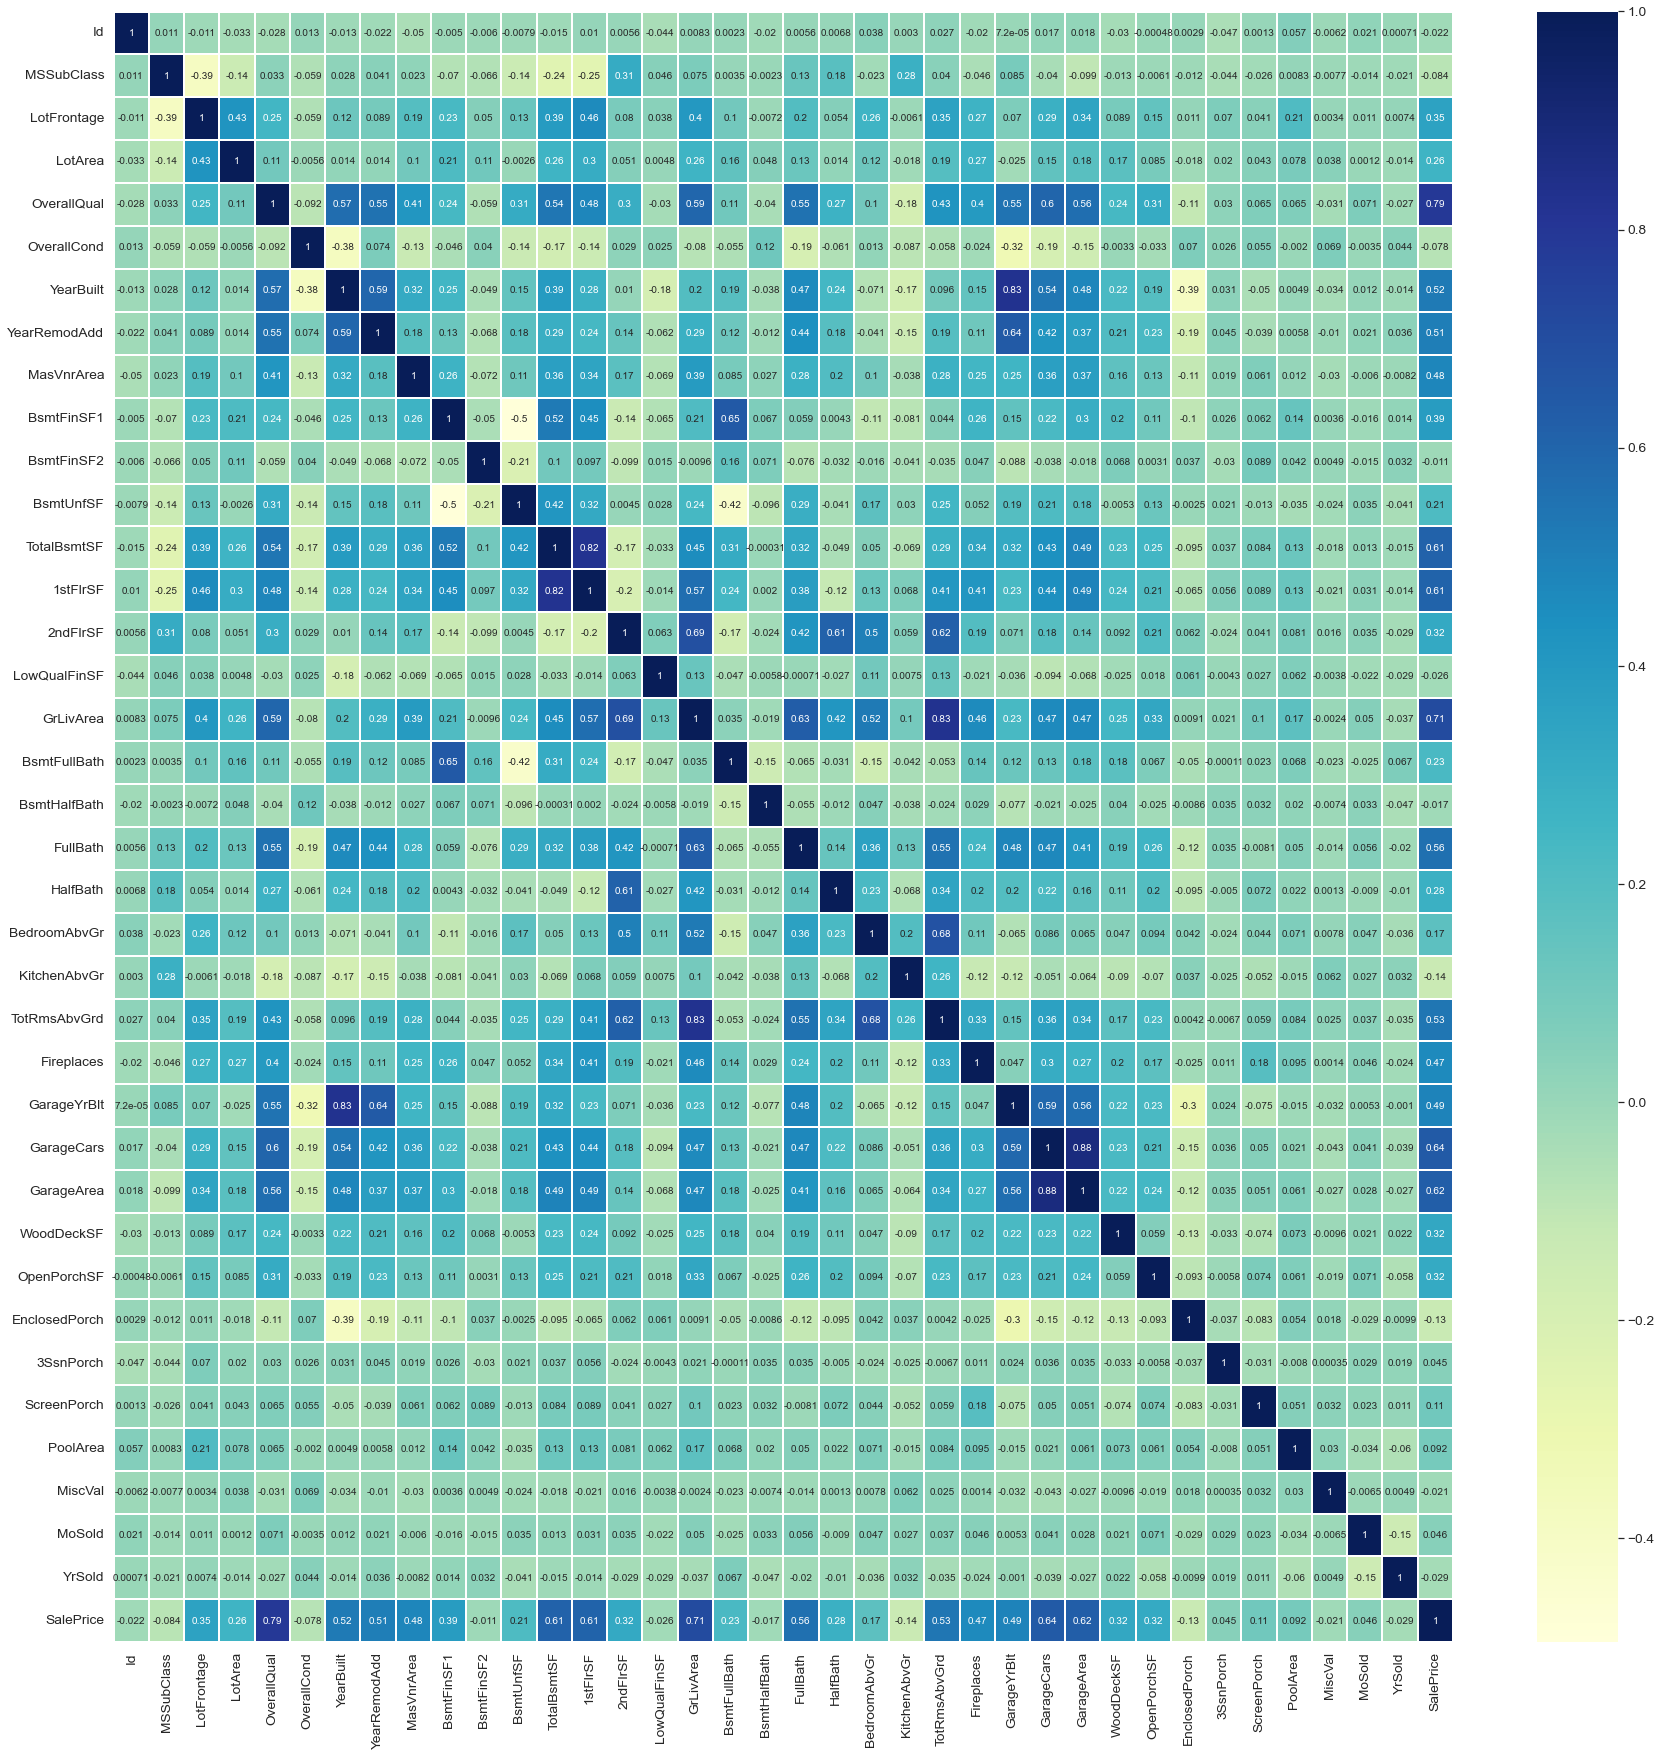

In [23]:
corrmat = df_train.corr()
f, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(corrmat, annot=True, cmap="YlGnBu", linewidths=0.1, annot_kws={"fontsize":10});

### 'SalePrice' correlation matrix (zoomed heatmap style)

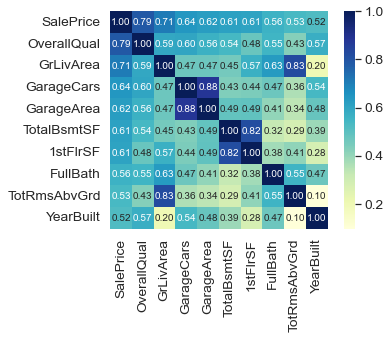

In [24]:
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cmap="YlGnBu", cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

'OverallQual', 'GrLivArea' and 'TotalBsmtSF' are strongly correlated with 'SalePrice'

# Missing data

In [25]:
#missing data
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])


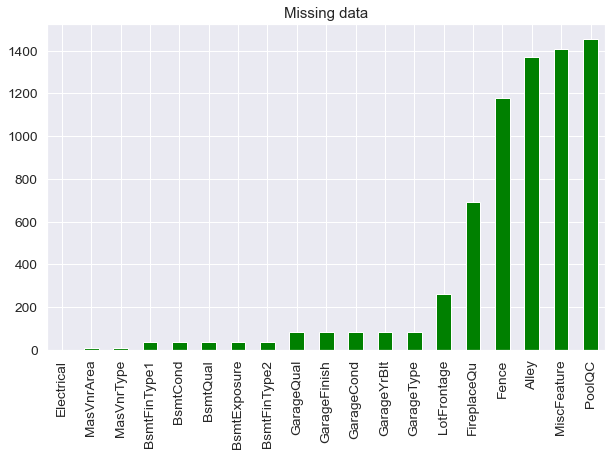

In [26]:
fig, ax = plt.subplots(figsize=(10,6))
deleted_data = missing_data[missing_data['Total'] >= 1]['Total'].copy()
deleted_data.sort_values(inplace=True)
ax.set_title('Missing data')
ax = deleted_data.plot.bar(color='green')

In [27]:
df_train = df_train.drop((missing_data[missing_data['Total'] >= 1]).index,axis = 1)
if not df_train.isnull().sum().max():
    print(f'Dataset hasnt zeros')
else:
    print(f'Dataset has {df_train.isnull().sum().max()} zeros')

Dataset hasnt zeros


# Preprocessing data

### Out liars

<AxesSubplot:xlabel='GrLivArea', ylabel='SalePrice'>

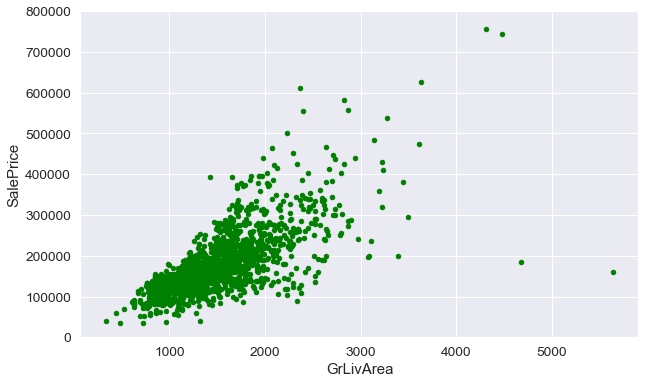

In [28]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([df_train['SalePrice'], df_train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000), color='green', figsize=(10,6))

In [29]:
# cloud points
df_train.sort_values(by = 'GrLivArea', ascending = False)[:2]

,Id,MSSubClass,MSZoning,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,LandSlope,...,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
1298,1299,60,RL,63887,Pave,IR3,Bnk,AllPub,Corner,Gtl,...,0,0,0,480,0,1,2008,New,Partial,160000
523,524,60,RL,40094,Pave,IR1,Bnk,AllPub,Inside,Gtl,...,0,0,0,0,0,10,2007,New,Partial,184750


In [30]:
# deleting points
df_train = df_train.drop(df_train[df_train['Id'] == 1299].index)
df_train = df_train.drop(df_train[df_train['Id'] == 524].index)

In [31]:
x = df_train.drop('Id', inplace=True, axis=1) 
x = df_train.drop(['SalePrice'], axis=1).select_dtypes(exclude=['object']) # select all the columns except the columns with data type object
y = df_train['SalePrice']

### Train|test split

In [32]:
x_train, x_test, y_train, y_test = train_test_split(x.to_numpy(), y.to_numpy(), test_size=0.25, random_state=42)

# imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
# # Imputation transformer for completing missing values. (nan to mean)
# x_train = imp_mean.fit_transform(x_train) 
# x_test = imp_mean.fit_transform(x_test)

# Decision Trees

In [33]:
max_depth = [3, 4, 5, 6, 7, 8, 10]
models = {}
errors = {}
count = 0
for a in max_depth:
    decision_tree = DecisionTreeRegressor(max_depth=a).fit(x_train, y_train)
    predicted_dt = decision_tree.predict(x_test)
    errors[count] = mean_absolute_error(y_test, predicted_dt)
    models[count] = decision_tree
    count +=1
    print(f'Mean absolute error of decision three model is {mean_absolute_error(y_test, predicted_dt)}')
min_error = [k for k,v in errors.items() if v == min(errors.values())]

Mean absolute error of decision three model is 29781.528368344425
Mean absolute error of decision three model is 28913.333423588705
Mean absolute error of decision three model is 25963.246153128875
Mean absolute error of decision three model is 24726.014318707807
Mean absolute error of decision three model is 24273.649901080636
Mean absolute error of decision three model is 23684.951925287518
Mean absolute error of decision three model is 23772.412626591104


In [34]:
print(f'Square root of {type(models[min_error[0]]).__name__} is {models[min_error[0]].score(x_train, y_train)}')
print(f'Square root of {type(models[min_error[0]]).__name__} is {models[min_error[0]].score(x_test, y_test)}')

Square root of DecisionTreeRegressor is 0.9634591714859452
Square root of DecisionTreeRegressor is 0.8120504867805318


# Random Forest


In [35]:
n_estimators = [100, 200, 300, 400, 500, 1000]
models = {}
errors = {}
count = 0
for a in n_estimators:
    random_forest = RandomForestRegressor(n_estimators=a, max_depth=10).fit(x_train, y_train)
    predicted_rf = random_forest.predict(x_test)
    errors[count] = mean_absolute_error(y_test, predicted_rf)
    models[count] = random_forest
    count +=1
    print(f'Mean absolute error of decision three model is {mean_absolute_error(y_test, predicted_rf)}')
min_error = [k for k,v in errors.items() if v == min(errors.values())]

Mean absolute error of decision three model is 16881.07016713383
Mean absolute error of decision three model is 16780.016328029255
Mean absolute error of decision three model is 16813.594062843003
Mean absolute error of decision three model is 16532.18675278179
Mean absolute error of decision three model is 16678.732140678258
Mean absolute error of decision three model is 16717.587341938477


In [36]:
print(f'Square root of {type(models[min_error[0]]).__name__} is {models[min_error[0]].score(x_train, y_train)}')
print(f'Square root of {type(models[min_error[0]]).__name__} is {models[min_error[0]].score(x_test, y_test)}')

Square root of RandomForestRegressor is 0.9794348550798754
Square root of RandomForestRegressor is 0.9034956169119531


# XGBOOST

In [37]:
n_estimators = [100, 200, 300, 400, 500, 1000]
max_depth = [3, 4, 5, 6, 7, 8, 10]
models = {}
errors = {}
count = 0
for a, b in zip(n_estimators, max_depth):
    xgboost = XGBRegressor(n_estimators=a, max_depth=b, eta=0.1, subsample=0.7, colsample_bytree=0.8).fit(x_train, y_train)
    predicted_xg = xgboost.predict(x_test)
    errors[count] = mean_absolute_error(y_test, predicted_xg)
    models[count] = xgboost
    count +=1
    print(f'Mean absolute error of decision three model is {mean_absolute_error(y_test, predicted_xg)}')
min_error = [k for k,v in errors.items() if v == min(errors.values())]

Mean absolute error of decision three model is 17068.562082619865
Mean absolute error of decision three model is 16031.903264126713
Mean absolute error of decision three model is 15960.061258561644
Mean absolute error of decision three model is 15937.911354880138
Mean absolute error of decision three model is 16021.06638484589
Mean absolute error of decision three model is 16149.527643407535


In [38]:
print(f'Square root of {type(models[min_error[0]]).__name__} is {models[min_error[0]].score(x_train, y_train)}')
print(f'Square root of {type(models[min_error[0]]).__name__} is {models[min_error[0]].score(x_test, y_test)}')

Square root of XGBRegressor is 0.9999511495221125
Square root of XGBRegressor is 0.9185897234051836


# Feature importances

In [39]:
def plot_feature_importance(importance,names,model_type):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

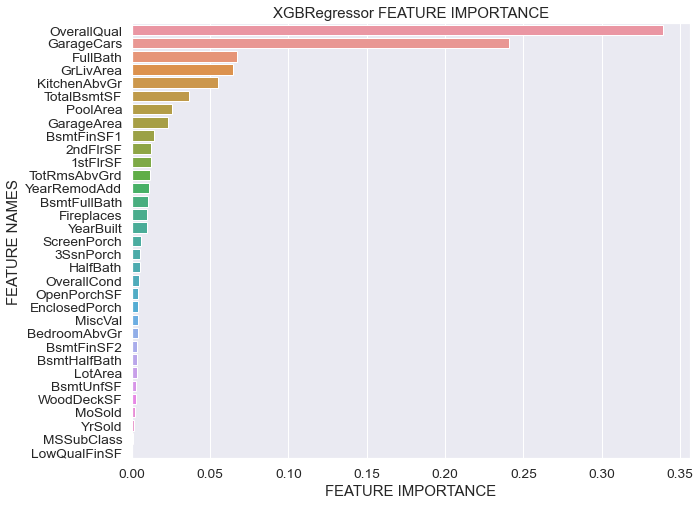

In [40]:
plot_feature_importance(xgboost.feature_importances_,x.columns,'XGBRegressor')

# Submission

In [43]:
test_csv = pd.read_csv("files/Houses_test.csv")
test_csv

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


In [44]:
# select all the columns except the columns with data type object
test_csv = test_csv.drop(['Id'], axis=1).select_dtypes(exclude=['object']) 
# delete difference between columns of DataFrames
test_csv = test_csv.drop(test_csv.columns.difference(x.columns), axis=1)
test_csv

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,20,11622,5,6,1961,1961,468.0,144.0,270.0,882.0,...,730.0,140,0,0,0,120,0,0,6,2010
1,20,14267,6,6,1958,1958,923.0,0.0,406.0,1329.0,...,312.0,393,36,0,0,0,0,12500,6,2010
2,60,13830,5,5,1997,1998,791.0,0.0,137.0,928.0,...,482.0,212,34,0,0,0,0,0,3,2010
3,60,9978,6,6,1998,1998,602.0,0.0,324.0,926.0,...,470.0,360,36,0,0,0,0,0,6,2010
4,120,5005,8,5,1992,1992,263.0,0.0,1017.0,1280.0,...,506.0,0,82,0,0,144,0,0,1,2010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,160,1936,4,7,1970,1970,0.0,0.0,546.0,546.0,...,0.0,0,0,0,0,0,0,0,6,2006
1455,160,1894,4,5,1970,1970,252.0,0.0,294.0,546.0,...,286.0,0,24,0,0,0,0,0,4,2006
1456,20,20000,5,7,1960,1996,1224.0,0.0,0.0,1224.0,...,576.0,474,0,0,0,0,0,0,9,2006
1457,85,10441,5,5,1992,1992,337.0,0.0,575.0,912.0,...,0.0,80,32,0,0,0,0,700,7,2006


In [ ]:
# look at where 'SalePrices' is null and replace df_train
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
test_csv = imp_mean.fit_transform(test_csv) 

In [ ]:
models = [decision_tree, random_forest, xgboost]
for model in models:
    RMS = mean_squared_error(np.log(sub_csv['SalePrice']), np.log(model.predict(test_csv)), squared=False)
    print(f'Root-Mean-Squared-Error of {type(model).__name__} is {RMS}')
    
    data = pd.concat([sub_csv['Id'], pd.Series(model.predict(test_csv))], axis=1)
    data.rename(columns={"Id": "Id", 0: "SalePrice"}, inplace=True)
    data.to_csv(f'{type(model).__name__}_submission.csv', index=False)
#     data.info()
    print(f'Submission of {type(model).__name__} was successfully saved!')